# Let's Dive into CNNs
## Please read the following paragraph I copy-pasted from ChatGPT:
Welcome back to the exciting world of Convolutional Neural Networks (CNN), building on our previous question which focused on Multilayer Perceptrons (MLP)! As you already know, CNNs are a powerful tool for image and video processing applications. They are designed to recognize patterns and features in visual data, making them a popular choice in computer vision research. One of the reasons why CNNs are preferred over MLPs for image recognition tasks is their ability to handle high-dimensional input data, which preserves spatial information by applying convolutional filters to detect patterns and features at different locations in the input data.

One of the reasons why CNNs are preferred over MLPs for image recognition tasks is their ability to handle high-dimensional input data. MLPs are limited in their ability to process images because they require that the input data be flattened into a one-dimensional vector, which can result in a loss of important spatial information. In contrast, CNNs are designed to handle multi-dimensional data such as images, preserving spatial information by applying convolutional filters to detect patterns and features at different locations in the input data.

In this assignment, we will be playing with the CIFAR-10 dataset to explore different CNN models. We will start by training an auto-encoder for CIFAR images. This auto-encoder will allow us to compare different models, including a Multilayer Perceptron (MLP) model, a CNN-MLP mixed model, and finally a CNN-only model. By comparing the performance of these models, we can gain a deeper understanding of the importance of CNN layers in image processing tasks.

Once we've completed our auto-encoder experiments, we will use the encoder from the best-performing model to train a Siamese network. Siamese networks are a type of neural network that can recognize similarity between two images, making them a popular choice for tasks such as image retrieval and face recognition. By training a Siamese network using the CIFAR-10 dataset, we can gain a better understanding of how CNNs can be used in more complex image recognition tasks.

Overall, this assignment will allow us to explore the many different applications of CNNs in image processing tasks. We'll have the opportunity to experiment with different architectures, compare their performance, and gain valuable insights into how CNNs can be used to solve real-world problems.

🫵Pro-tip: Utilize learnings from previous question to better solve problems in this question.

💭Trivia: Yes, I am allowed use ChatGPT!

## Part 0: Initialization
### Step zero: Import Libraries

In [67]:
# code here
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import random

### Step one: Using a PyTorch Dataset
Load CIFAR-10 dataset from `torchvision.datasets`. Keep batch_size >= 16.

In [68]:
torch.manual_seed(0)
random.seed(0)

In [69]:
# code here
transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=16, shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=16, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


torch.Size([16, 3, 32, 32])
torch.Size([16])


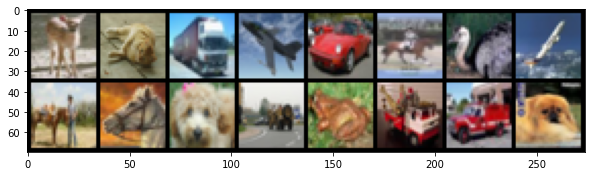

In [70]:
# let's have a look at the dataset
def imshow(img):
    img = img #/ 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# show images
imshow(torchvision.utils.make_grid(images))

## Part 1: Auto-Encoder
### Step one: Define 3 Models for Auto-Encoder
1. MLP-only model
2. CNN-MLP combination model
3. CNN-only model

In all the models, encoder and decoder should be consisting of $3$ layers each, and the encoder should be giving a flattened representation of size $32$.

Please see that each layer of encoder should decrease or keep equal the output size as compared to input size. Similarly, each layer of decoder should increase or keep equal the output size as compared to input size. 

In [ ]:
# class MLPAutoEncoder(nn.Module):
#     # code
# class ComboAutoEncoder(nn.Module):
#     # code
# class CNNAutoEncoder(nn.Module):
#     # code

In [71]:
class MLPAutoEncoder(nn.Module):
    def __init__(self):
        super(MLPAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3*32*32, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 32))

        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 3*32*32),
            nn.Sigmoid(),
            nn.Unflatten(1, (3, 32, 32))
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [72]:
class CNNAutoEncoder(nn.Module):
    def __init__(self):
        super(CNNAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=6, stride=2, padding=2), # 3x32x32 -> 8x16x16
            nn.ReLU(),
            nn.Conv2d(8, 4, kernel_size=6, stride=2, padding=2), # 8x16x16 -> 4x8x8
            nn.ReLU(),
            nn.Conv2d(4, 2, kernel_size=6, stride=2, padding=2), # 4x8x8 -> 2x4x4
            nn.ReLU(),
            nn.Flatten(),
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (2, 4, 4)),
            nn.ConvTranspose2d(2, 4, kernel_size=6, stride=2, padding=2), # 2x4x4 -> 4x8x8
            nn.ReLU(),
            nn.ConvTranspose2d(4, 8, kernel_size=6, stride=2, padding=2), # 4x8x8 -> 8x16x16
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, kernel_size=6, stride=2, padding=2), # 8x16x16 -> 3x32x32
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [73]:

class ComboAutoEncoder(nn.Module):
    def __init__(self):
        super(ComboAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(8 * 8 * 8, 32))
        self.decoder = nn.Sequential(
            nn.Linear(32, 8 * 8 * 8),
            nn.Unflatten(-1, (8, 8, 8)),
            # nn.ConvTranspose2d(4, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            # nn.ReLU(),
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2,
                               padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2,
                               padding=1, output_padding=1),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
# # sample code for a autoencoder:
# class Autoencoder(nn.Module):
#     def __init__(self):
#         super(Autoencoder, self).__init__()
#         # Input size: [batch, 3, 32, 32]
#         # Output size: [batch, 3, 32, 32]
#         # Representation size: 3072
#         # Number of Layers for encoder: 1
#         # Number of Layers for decoder: 1
#         self.encoder = nn.Sequential(
#             nn.Conv2d(3, 12, 4, stride=2, padding=1), # 3x32x32 -> 12x16x16
#             nn.ReLU(),
#             nn.Flatten(), # 12x16x16 -> 3072
#         )
#         self.decoder = nn.Sequential(
#             nn.Unflatten(1, (12, 16, 16)), # 3072 -> 12x16x16
#             nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1), # 12x16x16 -> 3x32x32
#             nn.Sigmoid(),
#         )
#     def forward(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return encoded, decoded


### Step two: Using MSELoss, train all the models and analyse results
Make sure you also discuss size, time-taken and any other differences you found. Plot MSELoss for each epoch for all models. Also, tabulate the final MSELosses of all models and plot it vis-a-vis:

1. Model Size
2. Model Parameters
3. Time Taken per epoch 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
criterion = nn.MSELoss()
criterion

MSELoss()

In [ ]:
def train_and_test_loss_eval(model, optimizer, epochs):

    train_losses = list()
    test_losses = list()

    for epoch in range(epochs):
        total_train_loss = 0.0
        total_val_loss = 0.0

        model.train()
        for images, _ in trainloader:
            images = images.to(device)

            outputs = model(images)
            loss = criterion(outputs, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        mean_train_loss = total_train_loss/len(trainloader.dataset)
        train_losses.append(mean_train_loss)

        model.eval()
        with torch.no_grad():
            for images, _ in testloader:
                images = images.to(device)
                outputs = model(images)
                loss = criterion(outputs, images)
                total_val_loss += loss.item()

        mean_test_loss = total_val_loss / len(testloader)
        test_losses.append(mean_test_loss)

        print(
            f"Epoch [{epoch+1}], Training Loss: {train_losses[-1]:.6f}, Test Loss: {test_losses[-1]:.6f}", flush=True)

    return train_losses, test_losses


In [ ]:
mlp_encoder = MLPAutoEncoder()
mlp_encoder.to(device)
mlp_optimizer = optim.Adam(mlp_encoder.parameters(), lr=0.002)

mlp_train_loss, mlp_test_loss = train_and_test_loss_eval(mlp_encoder, mlp_optimizer, 10)


Epoch [1], Training Loss: 0.002072, Test Loss: 0.030317
Epoch [2], Training Loss: 0.001713, Test Loss: 0.026526
Epoch [3], Training Loss: 0.001634, Test Loss: 0.024982
Epoch [4], Training Loss: 0.001542, Test Loss: 0.024101
Epoch [5], Training Loss: 0.001469, Test Loss: 0.023723
Epoch [6], Training Loss: 0.001457, Test Loss: 0.023308
Epoch [7], Training Loss: 0.001434, Test Loss: 0.022286
Epoch [8], Training Loss: 0.001374, Test Loss: 0.021511
Epoch [9], Training Loss: 0.001334, Test Loss: 0.021372
Epoch [10], Training Loss: 0.001324, Test Loss: 0.021275


In [ ]:
cnn_encoder = CNNAutoEncoder()
cnn_encoder.to(device)
cnn_optimizer = optim.Adam(cnn_encoder.parameters(), lr=0.002)

cnn_train_loss, cnn_test_loss = train_and_test_loss_eval(cnn_encoder, cnn_optimizer, 10)


Epoch [1], Training Loss: 0.001199, Test Loss: 0.016509
Epoch [2], Training Loss: 0.001033, Test Loss: 0.016600
Epoch [3], Training Loss: 0.001017, Test Loss: 0.016431
Epoch [4], Training Loss: 0.001007, Test Loss: 0.015932
Epoch [5], Training Loss: 0.000998, Test Loss: 0.015902
Epoch [6], Training Loss: 0.000993, Test Loss: 0.015779
Epoch [7], Training Loss: 0.000991, Test Loss: 0.015746
Epoch [8], Training Loss: 0.000989, Test Loss: 0.015755
Epoch [9], Training Loss: 0.000988, Test Loss: 0.015706
Epoch [10], Training Loss: 0.000987, Test Loss: 0.015648


In [ ]:
combo_encoder = ComboAutoEncoder()
combo_encoder.to(device)
combo_optimizer = optim.Adam(combo_encoder.parameters(), lr=0.002)

combo_train_loss, combo_test_loss = train_and_test_loss_eval(combo_encoder, combo_optimizer, 10)


Epoch [1], Training Loss: 0.001073, Test Loss: 0.013315
Epoch [2], Training Loss: 0.000815, Test Loss: 0.012831
Epoch [3], Training Loss: 0.000797, Test Loss: 0.012645
Epoch [4], Training Loss: 0.000790, Test Loss: 0.012582
Epoch [5], Training Loss: 0.000785, Test Loss: 0.012485
Epoch [6], Training Loss: 0.000780, Test Loss: 0.012454
Epoch [7], Training Loss: 0.000777, Test Loss: 0.012473
Epoch [8], Training Loss: 0.000768, Test Loss: 0.012216
Epoch [9], Training Loss: 0.000765, Test Loss: 0.012190
Epoch [10], Training Loss: 0.000762, Test Loss: 0.012182


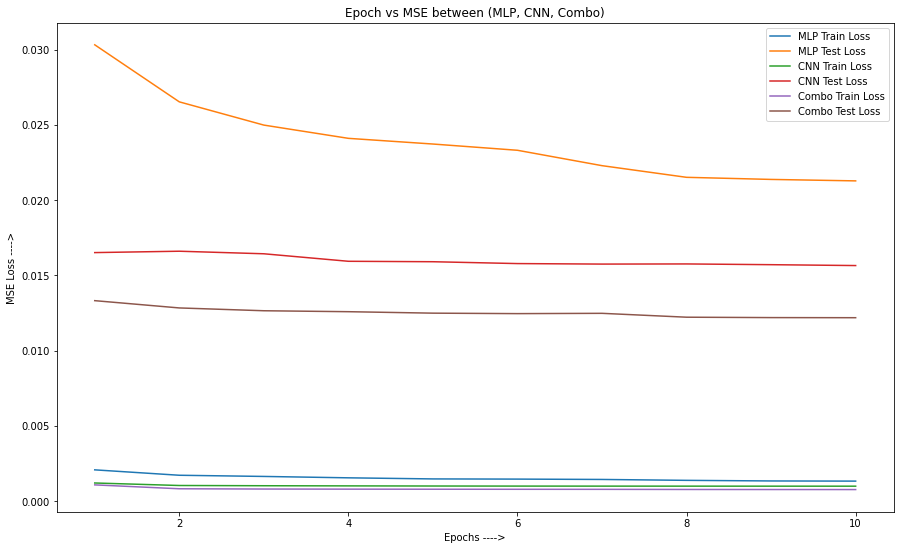

In [ ]:
plt.figure(figsize=(15, 9))

plt.title("Epoch vs MSE between (MLP, CNN, Combo)")
plt.plot(range(1, 11), mlp_train_loss, label='MLP Train Loss')
plt.plot(range(1, 11), mlp_test_loss, label='MLP Test Loss')
plt.plot(range(1, 11), cnn_train_loss, label='CNN Train Loss')
plt.plot(range(1, 11), cnn_test_loss, label='CNN Test Loss')
plt.plot(range(1, 11), combo_train_loss, label='Combo Train Loss')
plt.plot(range(1, 11), combo_test_loss, label='Combo Test Loss')
plt.legend()
plt.xlabel('Epochs ---->')
plt.ylabel('MSE Loss ---->')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# mlpEncoder = mlpEncoder.to(device)


def imshow(img):
    img = img.cpu()
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


dataiter = iter(testloader)
images, labels = next(dataiter)
images = images.to(device)


Original Images
Reconstructed Images with MLP Encoder


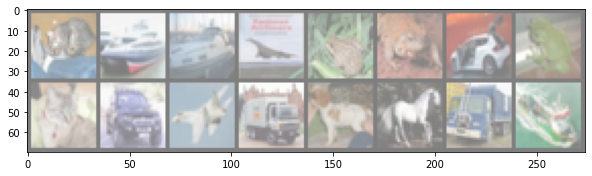

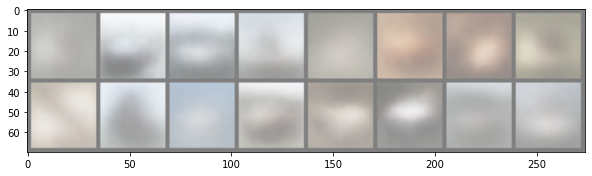

In [ ]:
print('Original Images')
imshow(torchvision.utils.make_grid(images))

with torch.no_grad():
    decoded_imgs = mlp_encoder(images)

print('Reconstructed Images with MLP Encoder')
imshow(torchvision.utils.make_grid(decoded_imgs))

plt.show()

Original Images
Reconstructed Images with CNN Encoder


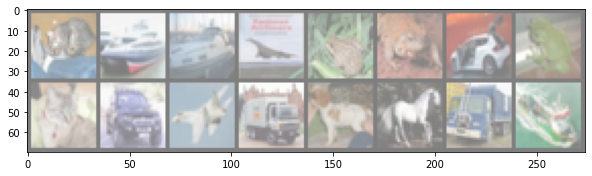

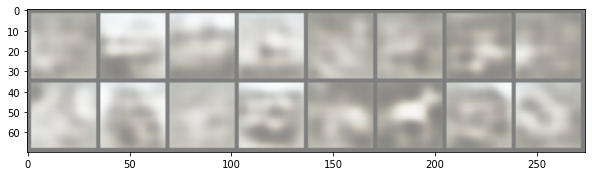

In [ ]:
print('Original Images')
imshow(torchvision.utils.make_grid(images))

with torch.no_grad():
    decoded_imgs = cnn_encoder(images)

print('Reconstructed Images with CNN Encoder')
imshow(torchvision.utils.make_grid(decoded_imgs))

plt.show()

Original Images
Reconstructed Images with Combo Encoder


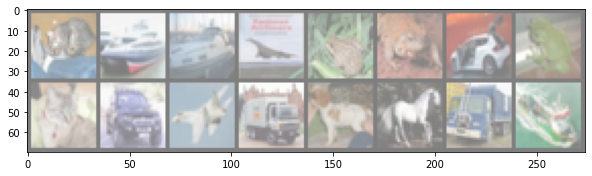

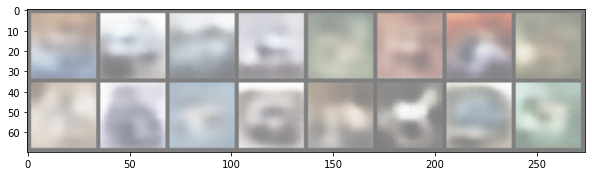

In [ ]:
print('Original Images')
imshow(torchvision.utils.make_grid(images))

with torch.no_grad():
    decoded_imgs = combo_encoder(images)

print('Reconstructed Images with Combo Encoder')
imshow(torchvision.utils.make_grid(decoded_imgs))

plt.show()

In [ ]:
from torchsummary import summary
mlp_encoder = MLPAutoEncoder()
summary(mlp_encoder, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                  [-1, 512]       1,573,376
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
            Linear-6                  [-1, 128]          32,896
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 32]           4,128
            Linear-9                  [-1, 128]           4,224
             ReLU-10                  [-1, 128]               0
           Linear-11                  [-1, 256]          33,024
             ReLU-12                  [-1, 256]               0
           Linear-13                  [-1, 512]         131,584
             ReLU-14                  [

In [ ]:
from torchsummary import summary
cnn_encoder = CNNAutoEncoder()
summary(cnn_encoder, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 16, 16]             872
              ReLU-2            [-1, 8, 16, 16]               0
            Conv2d-3              [-1, 4, 8, 8]           1,156
              ReLU-4              [-1, 4, 8, 8]               0
            Conv2d-5              [-1, 2, 4, 4]             290
              ReLU-6              [-1, 2, 4, 4]               0
           Flatten-7                   [-1, 32]               0
         Unflatten-8              [-1, 2, 4, 4]               0
   ConvTranspose2d-9              [-1, 4, 8, 8]             292
             ReLU-10              [-1, 4, 8, 8]               0
  ConvTranspose2d-11            [-1, 8, 16, 16]           1,160
             ReLU-12            [-1, 8, 16, 16]               0
  ConvTranspose2d-13            [-1, 3, 32, 32]             867
          Sigmoid-14            [-1, 3,

In [ ]:
from torchsummary import summary
combo_encoder = ComboAutoEncoder()
summary(combo_encoder, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4            [-1, 8, 16, 16]           1,160
              ReLU-5            [-1, 8, 16, 16]               0
         MaxPool2d-6              [-1, 8, 8, 8]               0
           Flatten-7                  [-1, 512]               0
            Linear-8                   [-1, 32]          16,416
            Linear-9                  [-1, 512]          16,896
        Unflatten-10              [-1, 8, 8, 8]               0
  ConvTranspose2d-11           [-1, 16, 16, 16]           1,168
             ReLU-12           [-1, 16, 16, 16]               0
  ConvTranspose2d-13            [-1, 3, 32, 32]             435
          Sigmoid-14            [-1, 3,

**Observations**<br>
MLP-only model: <br>
Model size: 13.43 MB
Number of model parameters: 3,486,496
Time per Epoch: 18.6 seconds

    
CNN-only model: <br>
Model size: 0.15 MB
Number of model parameters: 4,637
Time per Epoch: 23.4 seconds


CNN-MLP combination model: <br>
Model size: 0.59 MB
Number of model parameters: 36,523
Time per Epoch: 25.5 seconds

- The Combo model seems to be the best in terms of performance. 
- But if we look at the size, CNN is much lighter than Combo model. So, the size to performnace is reasonable in CNN model.

In [ ]:
# # Utilize the following code
# #--------------MLP--------------#
# dataiter = iter(testloader)
# images, labels = dataiter.next()
# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
# imshow(torchvision.utils.make_grid(images))

# images = Variable(images)

# print("Reconstructed image")
# decoded_imgs = autoencoder(images)[1]
# imshow(torchvision.utils.make_grid(decoded_imgs.data))

# #--------------Combo--------------#
# dataiter = iter(testloader)
# images, labels = dataiter.next()
# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
# imshow(torchvision.utils.make_grid(images))

# images = Variable(images)

# print("Reconstructed image")
# decoded_imgs = autoencoder(images)[1]
# imshow(torchvision.utils.make_grid(decoded_imgs.data))

# #--------------CNN--------------#
# dataiter = iter(testloader)
# images, labels = dataiter.next()
# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
# imshow(torchvision.utils.make_grid(images))

# images = Variable(images)

# print("Reconstructed image")
# decoded_imgs = autoencoder(images)[1]
# imshow(torchvision.utils.make_grid(decoded_imgs.data))

In [ ]:
# analysis, plots and tabulations here

### Step three: Let's play with Representation Sizes
Spoilers: You must have found CNN to be more effective.

Have you ever wondered how varying the size of a CNN auto-encoder's representation can affect its performance? If so, here's a challenge for you: Implement a CNN auto-encoder with different representation sizes and observe the impact on the reconstruction quality.

Play with the following representation sizes:
1. 10
2. 32
3. 100
4. 1000

When working with different representation sizes in a CNN auto-encoder, we may reach a point of diminishing returns where increasing the representation size does not lead to significant improvements in reconstruction quality. This can be due to factors such as increased model complexity and longer training times. Discuss where you feel we might reach this point of diminishing returns when working with CIFAR-10 dataset and varying representation sizes.

Do analysis as suggested earlier.

In [ ]:
# code and analysis here

In [ ]:
class CNNRepEncoder10(nn.Module):
    
    # 3x32x32 -> 1x1x10 -> 3x32x32

    def __init__(self):

        super(CNNRepEncoder10, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 160, kernel_size=4, stride=2, padding=1), # 3x32x32 -> 160x16x16
            nn.ReLU(),
            nn.Conv2d(160, 80, kernel_size=4, stride=2, padding=1), # 160x16x16 -> 80x8x8
            nn.ReLU(),
            nn.Conv2d(80, 40, kernel_size=4, stride=2, padding=1), # 80x8x8 -> 4x4x40
            nn.ReLU(),
            nn.Conv2d(40, 20, kernel_size=4, stride=2, padding=1), # 4x4x40 -> 2x2x20
            nn.ReLU(),
            nn.Conv2d(20, 10, kernel_size=4, stride=2, padding=1), # 2x2x20 -> 1x1x10 = 10
            nn.ReLU(),
            nn.Flatten()
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(-1, (10, 1, 1)),
            nn.ConvTranspose2d(10, 20, kernel_size=4, stride=2, padding=1), # 1x1x10 -> 2x2x20
            nn.ReLU(),
            nn.ConvTranspose2d(20, 40, kernel_size=4, stride=2, padding=1), # 2x2x20 -> 4x4x40
            nn.ReLU(),
            nn.ConvTranspose2d(40, 80, kernel_size=4, stride=2, padding=1), # 4x4x40 -> 80x8x8
            nn.ReLU(), 
            nn.ConvTranspose2d(80, 160, kernel_size=4, stride=2, padding=1), # 80x8x8 -> 160x16x16
            nn.ReLU(),
            nn.ConvTranspose2d(160, 3, kernel_size=4, stride=2, padding=1), # 160x16x16 -> 3x32x32
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
class CNNRepEncoder32(nn.Module):

    # 3x32x32 -> 2x4x4 -> 3x32x32

    def __init__(self):
        super(CNNRepEncoder32, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=6, stride=2, padding=2), # 3x32x32 -> 8x16x16
            nn.ReLU(),
            nn.Conv2d(8, 4, kernel_size=6, stride=2, padding=2), # 8x16x16 -> 4x8x8
            nn.ReLU(),
            nn.Conv2d(4, 2, kernel_size=6, stride=2, padding=2), # 4x8x8 -> 2x4x4 = 32
            nn.ReLU(),
            nn.Flatten(),
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (2, 4, 4)),
            nn.ConvTranspose2d(2, 4, kernel_size=6, stride=2, padding=2), # 2x4x4 -> 4x8x8
            nn.ReLU(),
            nn.ConvTranspose2d(4, 8, kernel_size=6, stride=2, padding=2), # 4x8x8 -> 8x16x16
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, kernel_size=6, stride=2, padding=2), # 8x16x16 -> 3x32x32
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
class CNNRepEncoder100(nn.Module):

    # 3x32x32 -> 25x2x2 -> 3x32x32

    def __init__(self):
        super(CNNRepEncoder100, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 200, kernel_size=2, stride=2, padding=0), # 3x32x32 -> 200x16x16
            nn.ReLU(),
            nn.Conv2d(200, 100, kernel_size=2, stride=2, padding=0), # 200x16x16 -> 100x8x8
            nn.ReLU(),
            nn.Conv2d(100, 50, kernel_size=2, stride=2, padding=0), # 100x8x8 -> 50x4x4
            nn.ReLU(),
            nn.Conv2d(50, 25, kernel_size=2, stride=2, padding=0), # 50x4x4 -> 25x2x2 = 100
            nn.ReLU(),
            nn.Flatten(),
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (25, 2, 2)),
            nn.ConvTranspose2d(25, 50, kernel_size=2, stride=2, padding=0), # 25x2x2 -> 50x4x4
            nn.ReLU(),
            nn.ConvTranspose2d(50, 100, kernel_size=2, stride=2, padding=0), # 50x4x4 -> 100x8x8
            nn.ReLU(),
            nn.ConvTranspose2d(100, 200, kernel_size=2, stride=2, padding=0), # 100x8x8 -> 200x16x16
            nn.ReLU(),
            nn.ConvTranspose2d(200, 3, kernel_size=2, stride=2, padding=0), # 200x16x16 -> 3x32x32
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
class CNNRepEncoder1000(nn.Module):
    # 3x32x32 -> 10x10x10 -> 3x32x32
    def __init__(self):
        super(CNNRepEncoder1000, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 320, kernel_size=5, stride=1, padding=0), # 3x32x32 -> 320x28x28
            nn.ReLU(),
            nn.Conv2d(320, 160, kernel_size=5, stride=1, padding=0), # 320x28x28 -> 160x24x24
            nn.ReLU(),
            nn.Conv2d(160, 80, kernel_size=5, stride=1, padding=0), # 160x24x24 -> 80x20x20
            nn.ReLU(),
            nn.Conv2d(80, 40, kernel_size=5, stride=1, padding=0), # 80x20x20 -> 40x16x16
            nn.ReLU(),
            nn.Conv2d(40, 20, kernel_size=4, stride=1, padding=0), # 40x16x16 -> 20x13x13
            nn.ReLU(),
            nn.Conv2d(20, 10, kernel_size=4, stride=1, padding=0), # 20x13x13 -> 10x10x10 = 1000
            nn.ReLU(),
            nn.Flatten(),
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (10, 10, 10)),
            nn.ConvTranspose2d(10, 20, kernel_size=4, stride=1, padding=0), # 10x10x10 -> 20x13x13
            nn.ReLU(),
            nn.ConvTranspose2d(20, 40, kernel_size=4, stride=1, padding=0), # 20x13x13 -> 40x16x16
            nn.ReLU(),
            nn.ConvTranspose2d(40, 80, kernel_size=5, stride=1, padding=0), # 40x16x16 -> 80x20x20
            nn.ReLU(),
            nn.ConvTranspose2d(80, 160, kernel_size=5, stride=1, padding=0), # 80x20x20 -> 160x24x24
            nn.ReLU(),
            nn.ConvTranspose2d(160, 320, kernel_size=5, stride=1, padding=0), # 160x24x24 -> 320x28x28
            nn.ReLU(),
            nn.ConvTranspose2d(320, 3, kernel_size=5, stride=1, padding=0), # 320x28x28 -> 3x32x32
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
# code and analysis here
cnn_encoder_rep_10 = CNNRepEncoder10()
cnn_encoder_rep_10.to(device)
cnn_optimizer_10 = optim.Adam(cnn_encoder_rep_10.parameters(), lr=0.002)

cnn_rep10_train_loss, cnn_rep10_test_loss = train_and_test_loss_eval(cnn_encoder_rep_10, cnn_optimizer_10, 10)


Epoch [1], Training Loss: 0.001684, Test Loss: 0.023982
Epoch [2], Training Loss: 0.001468, Test Loss: 0.023322
Epoch [3], Training Loss: 0.001454, Test Loss: 0.023135
Epoch [4], Training Loss: 0.001443, Test Loss: 0.023090
Epoch [5], Training Loss: 0.001436, Test Loss: 0.022902
Epoch [6], Training Loss: 0.001430, Test Loss: 0.023093
Epoch [7], Training Loss: 0.001426, Test Loss: 0.022782
Epoch [8], Training Loss: 0.001422, Test Loss: 0.022739
Epoch [9], Training Loss: 0.001420, Test Loss: 0.022733
Epoch [10], Training Loss: 0.001417, Test Loss: 0.022874


In [ ]:
# code and analysis here
cnn_encoder_rep_32 = CNNRepEncoder32()
cnn_encoder_rep_32.to(device)
cnn_optimizer_32 = optim.Adam(cnn_encoder_rep_32.parameters(), lr=0.002)

cnn_rep32_train_loss, cnn_rep32_test_loss = train_and_test_loss_eval(cnn_encoder_rep_32, cnn_optimizer_32, 10)


Epoch [1], Training Loss: 0.001236, Test Loss: 0.016729
Epoch [2], Training Loss: 0.001038, Test Loss: 0.016353
Epoch [3], Training Loss: 0.001009, Test Loss: 0.016071
Epoch [4], Training Loss: 0.000998, Test Loss: 0.015930
Epoch [5], Training Loss: 0.000993, Test Loss: 0.015766
Epoch [6], Training Loss: 0.000930, Test Loss: 0.014150
Epoch [7], Training Loss: 0.000886, Test Loss: 0.014040
Epoch [8], Training Loss: 0.000878, Test Loss: 0.014304
Epoch [9], Training Loss: 0.000875, Test Loss: 0.013843
Epoch [10], Training Loss: 0.000873, Test Loss: 0.013798


In [ ]:
# code and analysis here
cnn_encoder_rep_100 = CNNRepEncoder100()
cnn_encoder_rep_100.to(device)
cnn_optimizer_100 = optim.Adam(cnn_encoder_rep_100.parameters(), lr=0.002)

cnn_rep100_train_loss, cnn_rep100_test_loss = train_and_test_loss_eval(cnn_encoder_rep_100, cnn_optimizer_100, 10)


Epoch [1], Training Loss: 0.000769, Test Loss: 0.009683
Epoch [2], Training Loss: 0.000588, Test Loss: 0.009373
Epoch [3], Training Loss: 0.000577, Test Loss: 0.009503
Epoch [4], Training Loss: 0.000571, Test Loss: 0.009146
Epoch [5], Training Loss: 0.000565, Test Loss: 0.008980
Epoch [6], Training Loss: 0.000557, Test Loss: 0.008875
Epoch [7], Training Loss: 0.000553, Test Loss: 0.008795
Epoch [8], Training Loss: 0.000550, Test Loss: 0.008742
Epoch [9], Training Loss: 0.000547, Test Loss: 0.008712
Epoch [10], Training Loss: 0.000546, Test Loss: 0.008729


In [ ]:
# code and analysis here
cnn_encoder_rep_1000 = CNNRepEncoder1000()
cnn_encoder_rep_1000.to(device)
cnn_optimizer_1000 = optim.Adam(cnn_encoder_rep_1000.parameters(), lr=0.002)

cnn_rep1000_train_loss, cnn_rep1000_test_loss = train_and_test_loss_eval(cnn_encoder_rep_1000, cnn_optimizer_1000, 10)


Epoch [1], Training Loss: 0.001610, Test Loss: 0.020632
Epoch [2], Training Loss: 0.001245, Test Loss: 0.019281
Epoch [3], Training Loss: 0.001167, Test Loss: 0.017894
Epoch [4], Training Loss: 0.001122, Test Loss: 0.017456
Epoch [5], Training Loss: 0.001101, Test Loss: 0.017206
Epoch [6], Training Loss: 0.001067, Test Loss: 0.016621
Epoch [7], Training Loss: 0.001045, Test Loss: 0.016247
Epoch [8], Training Loss: 0.001028, Test Loss: 0.015994
Epoch [9], Training Loss: 0.001015, Test Loss: 0.017822
Epoch [10], Training Loss: 0.001001, Test Loss: 0.015844


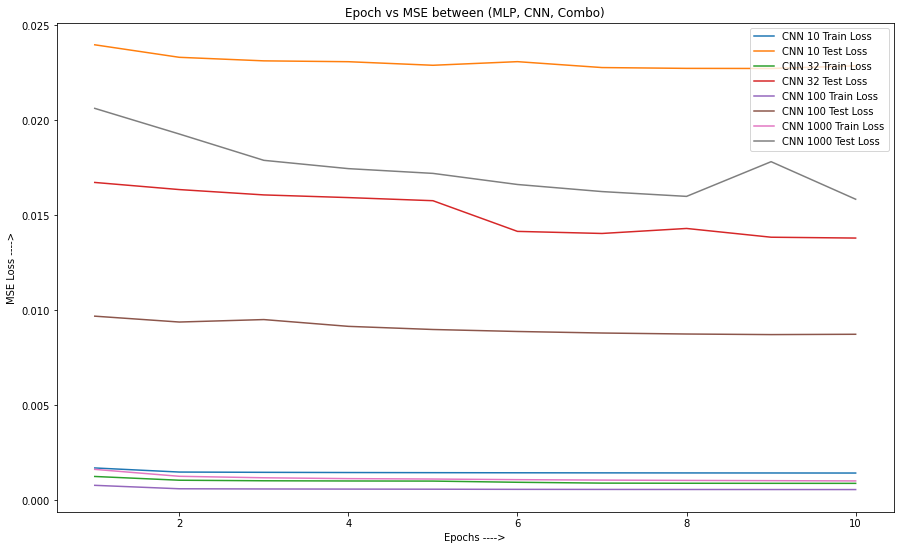

In [ ]:
plt.figure(figsize=(15, 9))

plt.title("Epoch vs MSE between (MLP, CNN, Combo)")
plt.plot(range(1, 11), cnn_rep10_train_loss, label='CNN 10 Train Loss')
plt.plot(range(1, 11), cnn_rep10_test_loss, label='CNN 10 Test Loss')
plt.plot(range(1, 11), cnn_rep32_train_loss, label='CNN 32 Train Loss')
plt.plot(range(1, 11), cnn_rep32_test_loss, label='CNN 32 Test Loss')
plt.plot(range(1, 11), cnn_rep100_train_loss, label='CNN 100 Train Loss')
plt.plot(range(1, 11), cnn_rep100_test_loss, label='CNN 100 Test Loss')
plt.plot(range(1, 11), cnn_rep1000_train_loss, label='CNN 1000 Train Loss')
plt.plot(range(1, 11), cnn_rep1000_test_loss, label='CNN 1000 Test Loss')
plt.legend()
plt.xlabel('Epochs ---->')
plt.ylabel('MSE Loss ---->')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# mlpEncoder = mlpEncoder.to(device)


def imshow(img):
    img = img.cpu()
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


dataiter = iter(testloader)
images, labels = next(dataiter)
images = images.to(device)


Original Images
Reconstructed Images with CNN Rep 10 Encoder


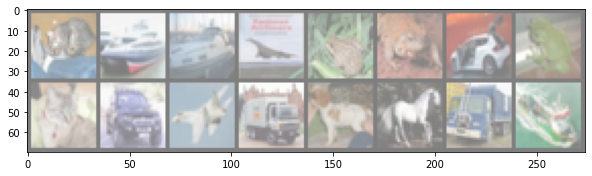

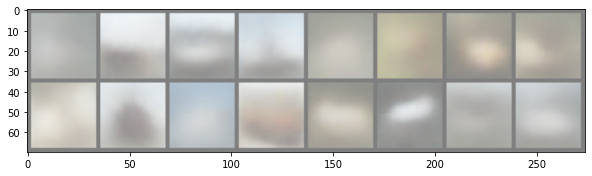

In [ ]:
print('Original Images')
imshow(torchvision.utils.make_grid(images))

with torch.no_grad():
    decoded_imgs = cnn_encoder_rep_10(images)

print('Reconstructed Images with CNN Rep 10 Encoder')
imshow(torchvision.utils.make_grid(decoded_imgs))

plt.show()

Original Images
Reconstructed Images with CNN Rep 32 Encoder


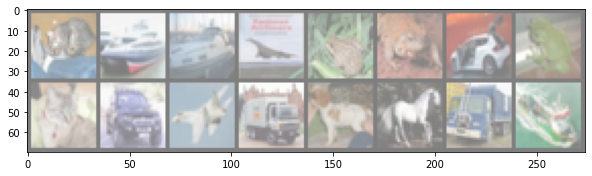

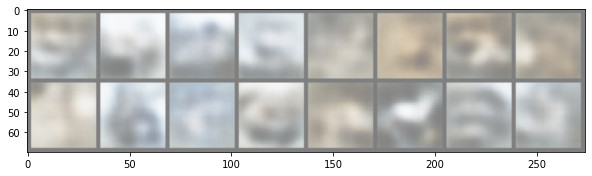

In [ ]:
print('Original Images')
imshow(torchvision.utils.make_grid(images))

with torch.no_grad():
    decoded_imgs = cnn_encoder_rep_32(images)

print('Reconstructed Images with CNN Rep 32 Encoder')
imshow(torchvision.utils.make_grid(decoded_imgs))

plt.show()

Original Images
Reconstructed Images with CNN Rep 100 Encoder


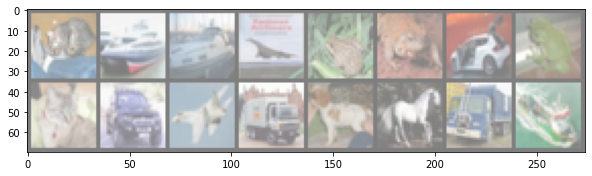

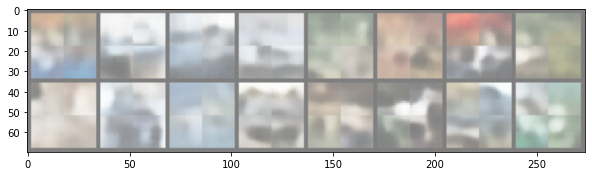

In [ ]:
print('Original Images')
imshow(torchvision.utils.make_grid(images))

with torch.no_grad():
    decoded_imgs = cnn_encoder_rep_100(images)

print('Reconstructed Images with CNN Rep 100 Encoder')
imshow(torchvision.utils.make_grid(decoded_imgs))

plt.show()

Original Images
Reconstructed Images with CNN Rep 1000 Encoder


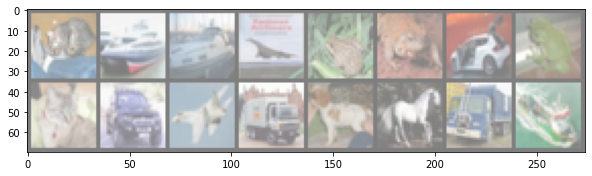

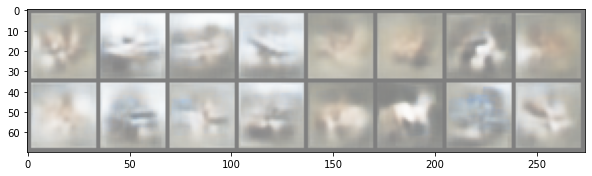

In [ ]:
print('Original Images')
imshow(torchvision.utils.make_grid(images))

with torch.no_grad():
    decoded_imgs = cnn_encoder_rep_1000(images)

print('Reconstructed Images with CNN Rep 1000 Encoder')
imshow(torchvision.utils.make_grid(decoded_imgs))

plt.show()

In [ ]:
from torchsummary import summary
cnn_encoder_rep_10 = CNNRepEncoder10()
summary(cnn_encoder_rep_10, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 160, 16, 16]           7,840
              ReLU-2          [-1, 160, 16, 16]               0
            Conv2d-3             [-1, 80, 8, 8]         204,880
              ReLU-4             [-1, 80, 8, 8]               0
            Conv2d-5             [-1, 40, 4, 4]          51,240
              ReLU-6             [-1, 40, 4, 4]               0
            Conv2d-7             [-1, 20, 2, 2]          12,820
              ReLU-8             [-1, 20, 2, 2]               0
            Conv2d-9             [-1, 10, 1, 1]           3,210
             ReLU-10             [-1, 10, 1, 1]               0
          Flatten-11                   [-1, 10]               0
        Unflatten-12             [-1, 10, 1, 1]               0
  ConvTranspose2d-13             [-1, 20, 2, 2]           3,220
             ReLU-14             [-1, 2

In [ ]:
from torchsummary import summary
cnn_encoder_rep_32 = CNNRepEncoder32()
summary(cnn_encoder_rep_32, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 16, 16]             872
              ReLU-2            [-1, 8, 16, 16]               0
            Conv2d-3              [-1, 4, 8, 8]           1,156
              ReLU-4              [-1, 4, 8, 8]               0
            Conv2d-5              [-1, 2, 4, 4]             290
              ReLU-6              [-1, 2, 4, 4]               0
           Flatten-7                   [-1, 32]               0
         Unflatten-8              [-1, 2, 4, 4]               0
   ConvTranspose2d-9              [-1, 4, 8, 8]             292
             ReLU-10              [-1, 4, 8, 8]               0
  ConvTranspose2d-11            [-1, 8, 16, 16]           1,160
             ReLU-12            [-1, 8, 16, 16]               0
  ConvTranspose2d-13            [-1, 3, 32, 32]             867
          Sigmoid-14            [-1, 3,

In [ ]:
from torchsummary import summary
cnn_encoder_rep_100 = CNNRepEncoder100()
summary(cnn_encoder_rep_100, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 200, 16, 16]           2,600
              ReLU-2          [-1, 200, 16, 16]               0
            Conv2d-3            [-1, 100, 8, 8]          80,100
              ReLU-4            [-1, 100, 8, 8]               0
            Conv2d-5             [-1, 50, 4, 4]          20,050
              ReLU-6             [-1, 50, 4, 4]               0
            Conv2d-7             [-1, 25, 2, 2]           5,025
              ReLU-8             [-1, 25, 2, 2]               0
           Flatten-9                  [-1, 100]               0
        Unflatten-10             [-1, 25, 2, 2]               0
  ConvTranspose2d-11             [-1, 50, 4, 4]           5,050
             ReLU-12             [-1, 50, 4, 4]               0
  ConvTranspose2d-13            [-1, 100, 8, 8]          20,100
             ReLU-14            [-1, 10

In [ ]:
from torchsummary import summary
cnn_encoder_rep_1000 = CNNRepEncoder1000()
summary(cnn_encoder_rep_1000, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 320, 28, 28]          24,320
              ReLU-2          [-1, 320, 28, 28]               0
            Conv2d-3          [-1, 160, 24, 24]       1,280,160
              ReLU-4          [-1, 160, 24, 24]               0
            Conv2d-5           [-1, 80, 20, 20]         320,080
              ReLU-6           [-1, 80, 20, 20]               0
            Conv2d-7           [-1, 40, 16, 16]          80,040
              ReLU-8           [-1, 40, 16, 16]               0
            Conv2d-9           [-1, 20, 13, 13]          12,820
             ReLU-10           [-1, 20, 13, 13]               0
           Conv2d-11           [-1, 10, 10, 10]           3,210
             ReLU-12           [-1, 10, 10, 10]               0
          Flatten-13                 [-1, 1000]               0
        Unflatten-14           [-1, 10,

**Observation**<br>
10 representations: <br>
Model Size: 3.62 MB
Parameters: 559,973
Epoch Time: 25.1 seconds

32 representations: <br>
Model Size: 0.15 MB
Parameters: 4,637
Epoch Time: 26.1 seconds

100 representations: <br>
Model Size: 2.67 MB
Parameters: 215,528
Epoch Time: 25.5 seconds

1000 representations: <br>
Model Size: 25.08 MB
Parameters: 3,441,253
Epoch Time: 25.5 seconds

- The accuracy and loss improves as representation size increases from 10 to 32 and 32 to 100. 

- So, at representation size 100, the results are the most optimal. 

- But, as we go towards representation size 1000, the accuracy and loss drops from representation size 100.

- At 1000 representations, as can be observed above the number of parameters used by the model are way too high and doesn't help in reducing the test loss at all and may even end up producing worse results due to overfitting.


### Step four: What about the number of layers?

Experimenting with different numbers of layers in the encoder and decoder of a CNN auto-encoder can have a significant impact on its performance with CIFAR-10 dataset. For our next challenge, let's explore how the number of layers can affect the quality of the reconstructed images. Would a deeper or shallower network be more effective for this task?

Play with the following numbers of layers for encoder and decoder each:
1. 1
2. 3
3. 5
4. 10

When experimenting with different numbers of layers in the encoder and decoder of a CNN auto-encoder, we may reach a point of diminishing returns where adding more layers does not result in significant improvements in reconstruction quality. Additionally, deeper networks may be prone to overfitting, especially when training data is limited. Discuss where you feel we reach it. 

Do analysis as suggested earlier.

In [ ]:
# code and analysis here

In [74]:
class CNN1(nn.Module):
    # 3x32x32 -> 2x4x4 -> 3x32x32
    def __init__(self):
        super(CNN1, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 2, kernel_size=8, stride=8, padding=0), # 3x32x32 -> 2x4x4
            nn.ReLU(),
            nn.Flatten()
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(-1, (2, 4, 4)),
            nn.ConvTranspose2d(2, 3, kernel_size=8, stride=8, padding=0), # 2x4x4 -> 3x32x32
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [75]:
class CNN3(nn.Module):
    # 3x32x32 -> 2x4x4 -> 3x32x32
    def __init__(self):
        super(CNN3, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=6, stride=2, padding=2), # 3x32x32 -> 8x16x16
            nn.ReLU(),
            nn.Conv2d(8, 4, kernel_size=6, stride=2, padding=2), # 8x16x16 -> 4x8x8
            nn.ReLU(),
            nn.Conv2d(4, 2, kernel_size=6, stride=2, padding=2), # 4x8x8 -> 2x4x4 = 32
            nn.ReLU(),
            nn.Flatten(),
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (2, 4, 4)),
            nn.ConvTranspose2d(2, 4, kernel_size=6, stride=2, padding=2), # 2x4x4 -> 4x8x8
            nn.ReLU(),
            nn.ConvTranspose2d(4, 8, kernel_size=6, stride=2, padding=2), # 4x8x8 -> 8x16x16
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, kernel_size=6, stride=2, padding=2), # 8x16x16 -> 3x32x32
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
        

In [76]:
class CNN5(nn.Module):
    # 3x32x32 -> 2x4x4 -> 3x32x32
    def __init__(self):
        super(CNN5, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=8, stride=1, padding=0), # 3x32x32 -> 32x25x25
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=8, stride=1, padding=0), # 32x25x25 -> 16x18x18
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size=8, stride=1, padding=0), # 16x18x18 -> 8x11x11
            nn.ReLU(),
            nn.Conv2d(8, 4, kernel_size=5, stride=1, padding=0), # 8x11x11 -> 4x7x7
            nn.ReLU(),
            nn.Conv2d(4, 2, kernel_size=4, stride=1, padding=0), # 4x7x7 -> 2x4x4
            nn.ReLU(),
            nn.Flatten()
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(-1, (2, 4, 4)),
            nn.ConvTranspose2d(2, 4, kernel_size=4, stride=1, padding=0), # 2x4x4 -> 4x7x7 
            nn.ReLU(),
            nn.ConvTranspose2d(4, 8, kernel_size=5, stride=1, padding=0), # 4x7x7 -> 8x11x11
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, kernel_size=8, stride=1, padding=0), # 8x11x11 -> 16x18x18
            nn.ReLU(),
            nn.ConvTranspose2d(16, 32, kernel_size=8, stride=1, padding=0), # 16x18x18 -> 32x25x25
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=8, stride=1, padding=0), # 32x25x25 -> 3x32x32
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [77]:
class CNN10(nn.Module):
    # 3x32x32 -> 2x4x4 -> 3x32x32
    def __init__(self):
        super(CNN10, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 1024, kernel_size=3, stride=1, padding=0), # 3x32x32 -> 1024x30x30
            nn.ReLU(),
            nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=0), # 1024x30x30 -> 512x28x28
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=0), # 512x28x28 -> 256x26x26
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=0), # 256x26x26 -> 128x24x24
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=0), # 128x24x24 -> 64x22x22
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=4, stride=1, padding=0), # 64x22x22 -> 32x19x19
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=4, stride=1, padding=0), # 32x19x19 -> 16x16x16
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size=5, stride=1, padding=0), # 16x16x16 -> 8x12x12
            nn.ReLU(),
            nn.Conv2d(8, 4, kernel_size=5, stride=1, padding=0), # 8x12x12 -> 4x8x8
            nn.ReLU(),
            nn.Conv2d(4, 2, kernel_size=5, stride=1, padding=0), # 4x8x8 -> 2x4x4
            nn.ReLU(),
            nn.Flatten()
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (2, 4, 4)),
            nn.ConvTranspose2d(2, 4, kernel_size=5, stride=1, padding=0), # 2x4x4 -> 4x8x8
            nn.ReLU(),
            nn.ConvTranspose2d(4, 8, kernel_size=5, stride=1, padding=0), # 4x8x8 -> 8x12x12
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, kernel_size=5, stride=1, padding=0), # 8x12x12 -> 16x16x16
            nn.ReLU(),
            nn.ConvTranspose2d(16, 32, kernel_size=4, stride=1, padding=0), # 16x16x16 -> 32x19x19
            nn.ReLU(),
            nn.ConvTranspose2d(32, 64, kernel_size=4, stride=1, padding=0), # 32x19x19 -> 64x22x22
            nn.ReLU(),
            nn.ConvTranspose2d(64, 128, kernel_size=3, stride=1, padding=0), # 64x22x22 -> 128x24x24
            nn.ReLU(),
            nn.ConvTranspose2d(128, 256, kernel_size=3, stride=1, padding=0), # 128x24x24 -> 256x26x26
            nn.ReLU(),
            nn.ConvTranspose2d(256, 512, kernel_size=3, stride=1, padding=0), # 256x26x26 -> 512x28x28
            nn.ReLU(),
            nn.ConvTranspose2d(512, 1024, kernel_size=3, stride=1, padding=0), # 512x28x28 -> 1024x30x30
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 3, kernel_size=3, stride=1, padding=0), # 1024x30x30 -> 3x32x32
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
# code and analysis here
cnn_encoder_1 = CNN1()
cnn_encoder_1.to(device)
cnn_optimizer_1 = optim.Adam(cnn_encoder_1.parameters(), lr=0.002)

cnn1_train_loss, cnn1_test_loss = train_and_test_loss_eval(cnn_encoder_1, cnn_optimizer_1, 10)


Epoch [1], Training Loss: 0.001616, Test Loss: 0.020551
Epoch [2], Training Loss: 0.001257, Test Loss: 0.020067
Epoch [3], Training Loss: 0.001250, Test Loss: 0.020209
Epoch [4], Training Loss: 0.001249, Test Loss: 0.020015
Epoch [5], Training Loss: 0.001249, Test Loss: 0.020045
Epoch [6], Training Loss: 0.001249, Test Loss: 0.020081
Epoch [7], Training Loss: 0.001249, Test Loss: 0.020086
Epoch [8], Training Loss: 0.001248, Test Loss: 0.020033
Epoch [9], Training Loss: 0.001248, Test Loss: 0.020001
Epoch [10], Training Loss: 0.001248, Test Loss: 0.020019


In [ ]:
# code and analysis here
cnn_encoder_3 = CNN3()
cnn_encoder_3.to(device)
cnn_optimizer_3 = optim.Adam(cnn_encoder_3.parameters(), lr=0.002)

cnn3_train_loss, cnn3_test_loss = train_and_test_loss_eval(cnn_encoder_3, cnn_optimizer_3, 10)


Epoch [1], Training Loss: 0.001185, Test Loss: 0.016456
Epoch [2], Training Loss: 0.001021, Test Loss: 0.016777
Epoch [3], Training Loss: 0.001002, Test Loss: 0.015809
Epoch [4], Training Loss: 0.000993, Test Loss: 0.015754
Epoch [5], Training Loss: 0.000923, Test Loss: 0.014305
Epoch [6], Training Loss: 0.000880, Test Loss: 0.013922
Epoch [7], Training Loss: 0.000875, Test Loss: 0.013928
Epoch [8], Training Loss: 0.000872, Test Loss: 0.013819
Epoch [9], Training Loss: 0.000869, Test Loss: 0.014255
Epoch [10], Training Loss: 0.000868, Test Loss: 0.013918


In [ ]:
# code and analysis here
cnn_encoder_5 = CNN5()
cnn_encoder_5.to(device)
cnn_optimizer_5 = optim.Adam(cnn_encoder_5.parameters(), lr=0.002)

cnn5_train_loss, cnn5_test_loss = train_and_test_loss_eval(cnn_encoder_5, cnn_optimizer_5, 10)


Epoch [1], Training Loss: 0.002667, Test Loss: 0.038915
Epoch [2], Training Loss: 0.002447, Test Loss: 0.038486
Epoch [3], Training Loss: 0.002377, Test Loss: 0.036960
Epoch [4], Training Loss: 0.002325, Test Loss: 0.036921
Epoch [5], Training Loss: 0.002278, Test Loss: 0.037555
Epoch [6], Training Loss: 0.002225, Test Loss: 0.035389
Epoch [7], Training Loss: 0.002191, Test Loss: 0.036366
Epoch [8], Training Loss: 0.002159, Test Loss: 0.033978
Epoch [9], Training Loss: 0.002142, Test Loss: 0.034529
Epoch [10], Training Loss: 0.002128, Test Loss: 0.033960


In [ ]:
# code and analysis here
cnn_encoder_10 = CNN10()
cnn_encoder_10.to(device)
cnn_optimizer_10 = optim.Adam(cnn_encoder_10.parameters(), lr=0.002)

cnn10_train_loss, cnn10_test_loss = train_and_test_loss_eval(cnn_encoder_10, cnn_optimizer_10, 3)


Epoch [1], Training Loss: 0.003930, Test Loss: 0.062541
Epoch [2], Training Loss: 0.003921, Test Loss: 0.062544
Epoch [3], Training Loss: 0.003920, Test Loss: 0.062524


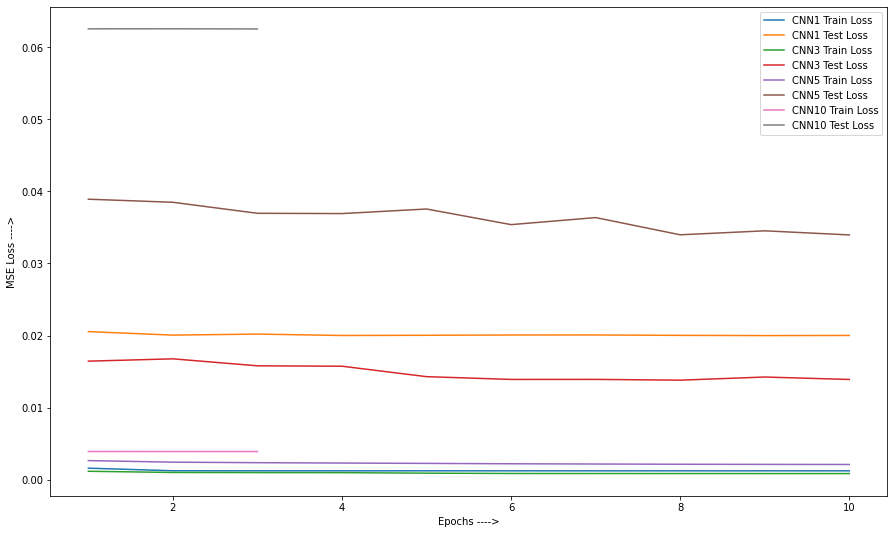

In [ ]:
plt.figure(figsize=(15, 9))

plt.plot(range(1, 11), cnn1_train_loss, label='CNN1 Train Loss')
plt.plot(range(1, 11), cnn1_test_loss, label='CNN1 Test Loss')
plt.plot(range(1, 11), cnn3_train_loss, label='CNN3 Train Loss')
plt.plot(range(1, 11), cnn3_test_loss, label='CNN3 Test Loss')
plt.plot(range(1, 11), cnn5_train_loss, label='CNN5 Train Loss')
plt.plot(range(1, 11), cnn5_test_loss, label='CNN5 Test Loss')
plt.plot(range(1, 4), cnn10_train_loss, label='CNN10 Train Loss')
plt.plot(range(1, 4), cnn10_test_loss, label='CNN10 Test Loss')

plt.legend()
plt.xlabel('Epochs ---->')
plt.ylabel('MSE Loss ---->')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# mlpEncoder = mlpEncoder.to(device)

def imshow(img):
    img = img.cpu()
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


dataiter = iter(testloader)
images, labels = next(dataiter)
images = images.to(device)


Original Images
Reconstructed Images with CNN 1 Encoder


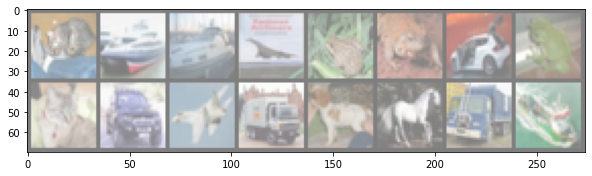

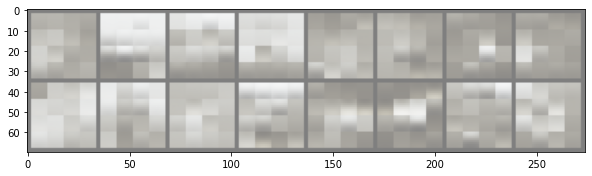

In [ ]:
print('Original Images')
imshow(torchvision.utils.make_grid(images))

with torch.no_grad():
    decoded_imgs = cnn_encoder_1(images)

print('Reconstructed Images with CNN 1 Encoder')
imshow(torchvision.utils.make_grid(decoded_imgs))

plt.show()

Original Images
Reconstructed Images with CNN 3 Encoder


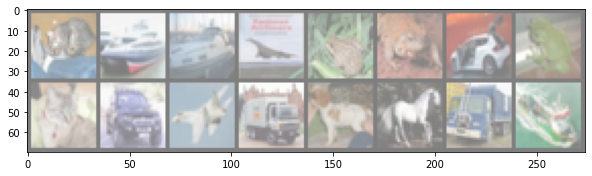

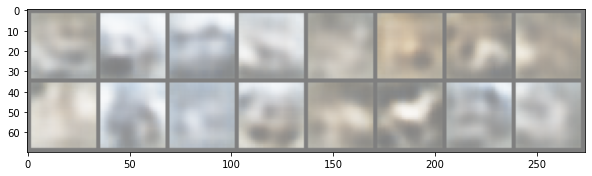

In [ ]:
print('Original Images')
imshow(torchvision.utils.make_grid(images))

with torch.no_grad():
    decoded_imgs = cnn_encoder_3(images)

print('Reconstructed Images with CNN 3 Encoder')
imshow(torchvision.utils.make_grid(decoded_imgs))

plt.show()

Original Images
Reconstructed Images with CNN 5 Encoder


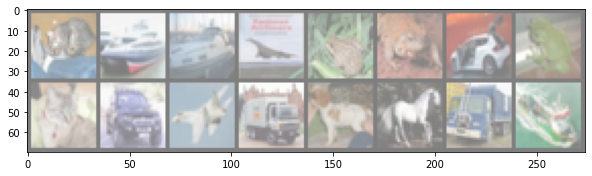

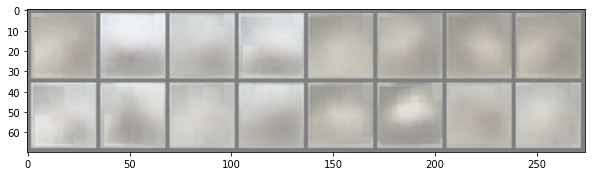

In [ ]:
print('Original Images')
imshow(torchvision.utils.make_grid(images))

with torch.no_grad():
    decoded_imgs = cnn_encoder_5(images)

print('Reconstructed Images with CNN 5 Encoder')
imshow(torchvision.utils.make_grid(decoded_imgs))

plt.show()

Original Images
Reconstructed Images with CNN 10 Encoder


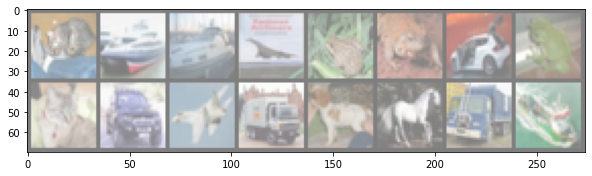

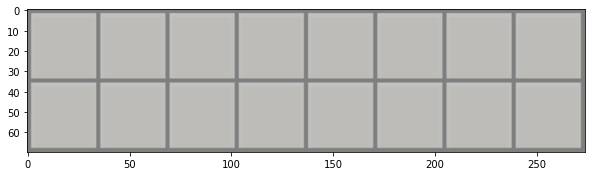

In [ ]:
print('Original Images')
imshow(torchvision.utils.make_grid(images))

with torch.no_grad():
    decoded_imgs = cnn_encoder_10(images)

print('Reconstructed Images with CNN 10 Encoder')
imshow(torchvision.utils.make_grid(decoded_imgs))

plt.show()

**NB:<br>**
The CNN 10 Encoder image reconstruction is not clear because we trained in too less epochs because it's taking too much time.

In [78]:
from torchsummary import summary
cnn_encoder_1 = CNN1()
summary(cnn_encoder_1, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1              [-1, 2, 4, 4]             386
              ReLU-2              [-1, 2, 4, 4]               0
           Flatten-3                   [-1, 32]               0
         Unflatten-4              [-1, 2, 4, 4]               0
   ConvTranspose2d-5            [-1, 3, 32, 32]             387
           Sigmoid-6            [-1, 3, 32, 32]               0
Total params: 773
Trainable params: 773
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.00
Estimated Total Size (MB): 0.06
----------------------------------------------------------------


In [79]:
from torchsummary import summary
cnn_encoder_3 = CNN3()
summary(cnn_encoder_3, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 16, 16]             872
              ReLU-2            [-1, 8, 16, 16]               0
            Conv2d-3              [-1, 4, 8, 8]           1,156
              ReLU-4              [-1, 4, 8, 8]               0
            Conv2d-5              [-1, 2, 4, 4]             290
              ReLU-6              [-1, 2, 4, 4]               0
           Flatten-7                   [-1, 32]               0
         Unflatten-8              [-1, 2, 4, 4]               0
   ConvTranspose2d-9              [-1, 4, 8, 8]             292
             ReLU-10              [-1, 4, 8, 8]               0
  ConvTranspose2d-11            [-1, 8, 16, 16]           1,160
             ReLU-12            [-1, 8, 16, 16]               0
  ConvTranspose2d-13            [-1, 3, 32, 32]             867
          Sigmoid-14            [-1, 3,

In [80]:
from torchsummary import summary
cnn_encoder_5 = CNN5()
summary(cnn_encoder_5, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 25, 25]           6,176
              ReLU-2           [-1, 32, 25, 25]               0
            Conv2d-3           [-1, 16, 18, 18]          32,784
              ReLU-4           [-1, 16, 18, 18]               0
            Conv2d-5            [-1, 8, 11, 11]           8,200
              ReLU-6            [-1, 8, 11, 11]               0
            Conv2d-7              [-1, 4, 7, 7]             804
              ReLU-8              [-1, 4, 7, 7]               0
            Conv2d-9              [-1, 2, 4, 4]             130
             ReLU-10              [-1, 2, 4, 4]               0
          Flatten-11                   [-1, 32]               0
        Unflatten-12              [-1, 2, 4, 4]               0
  ConvTranspose2d-13              [-1, 4, 7, 7]             132
             ReLU-14              [-1, 

In [81]:
from torchsummary import summary
cnn_encoder_10 = CNN10()
summary(cnn_encoder_10, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 1024, 30, 30]          28,672
              ReLU-2         [-1, 1024, 30, 30]               0
            Conv2d-3          [-1, 512, 28, 28]       4,719,104
              ReLU-4          [-1, 512, 28, 28]               0
            Conv2d-5          [-1, 256, 26, 26]       1,179,904
              ReLU-6          [-1, 256, 26, 26]               0
            Conv2d-7          [-1, 128, 24, 24]         295,040
              ReLU-8          [-1, 128, 24, 24]               0
            Conv2d-9           [-1, 64, 22, 22]          73,792
             ReLU-10           [-1, 64, 22, 22]               0
           Conv2d-11           [-1, 32, 19, 19]          32,800
             ReLU-12           [-1, 32, 19, 19]               0
           Conv2d-13           [-1, 16, 16, 16]           8,208
             ReLU-14           [-1, 16,

**Observations**<br>
1 Layer:
Model Size: 0.06 MB
Parameters: 773
Epoch Time: 16.5 seconds

3 Layer:
Model Size: 0.15 MB
Parameters: 4,637
Epoch Time: 24.1 seconds

5 Layer:
Model Size: 1.23 MB
Parameters: 96,189
Epoch Time: 38.6 seconds

10 Layer:
Model Size: 97.82 MB
Parameters: 12,683,469
Epoch Time: 388 seconds
 

- Based on the summary and plot of the model, it can be observed that when the number of layers exceeds 5, the model tends to overfit significantly. 
- This is due to the large increase in the number of parameters when adding layers compared to increasing representation. 
- Additionally, the 10-layer model not only overfits but also takes up more space than the other models. 
- The 3-layer model is similar in terms of the number of parameters to the representation experiment and performs well. 
- Therefore, selecting a model with 3-5 layers is the optimal choice.

### Explaination time!
Please write a short-essay explaining what AutoEncoder does, how it is different from other data-representation methods like PCA, t-SNE and Variational AutoEncoders. Also tell what were your take-outs from this experiment.

In [ ]:
# explainations here

- Autoencoders are a class of neural networks that use unsupervised learning to compress input data, usually images. They have two components: an encoder and a decoder. The encoder takes the input data and reduces it to a lower dimensional representation that can be used for various purposes. The decoder can then reconstruct the original output by decompressing this representation at any time. The main purpose of autoencoders is to learn a compressed representation of the input data.

- PCA is a method of reducing dimensionality linearly and is not suitable for non-linear data. On the other hand, t-SNE can be used for non-linear dimensionality reduction and is often employed for visualizing and exploring data. However, when it comes to achieving better results, autoencoders, which are based on neural networks, are a superior option.

- Variational AutoEncoders (VAEs) incorporate a probabilistic layer into their encoder and decoder architecture, making them capable of learning a continuous space. As a result, they are more adaptable and better suited for a wider range of data. In contrast, traditional encoders, like the ones used in the experiment discussed earlier, are discrete. VAEs are capable of generative tasks, whereas traditional encoders are typically used for reconstruction tasks.

- The task provided me with valuable insights into the programming and functioning of Convolutional Neural Networks (CNNs). I found it fascinating that adding an extra layer can have a significant impact on the model's performance. Additionally, despite the not-so-great results obtained in the K-Nearest Neighbors (KNN) experiment, it was remarkable to observe that the images could be compressed significantly while still preserving distinctive features that enable their differentiation.





## Part 2: The return of kNN
Autoencoder representations can be useful for a wide range of machine learning tasks beyond just reconstructing input data. For example, the output of an encoder can be used as a feature representation for classification using k-Nearest Neighbors (kNN) or other classifiers. Similarly, the encoded representations can be used for unsupervised tasks like clustering, where the model groups similar images together based on their feature representation. This makes autoencoders a versatile tool for feature learning, with the potential to enhance the performance of a wide range of machine learning algorithms.

Since we have already trained auto-encoder on CIFAR-10, we will employ the encoder from the CNN model with representation size of $10$. Using a subset of CIFAR-10 train and test datasets, each with 10,000 and 1000 samples respectively, with an equal number of samples for each class, implement kNN classification using the encoder output as features. Share your findings and accuracy, F1 score and other relavant metrics on the test set. What insights can you draw from the results?

You are allowed to use sklearn or any other library for kNN and splitting dataset.

In [ ]:
# code and analysis here. Remember to keep your analysis of high quality at all times.

In [ ]:
# code and analysis here. Remember to keep your analysis of high quality at all time
from keras.datasets import cifar10
(X_train_full, y_train_full), (X_test_full, y_test_full) = cifar10.load_data()


In [ ]:
print(X_train_full)
print("==================")
print(y_train_full)


[[[[ 59  62  63]
   [ 43  46  45]
   [ 50  48  43]
   ...
   [158 132 108]
   [152 125 102]
   [148 124 103]]

  [[ 16  20  20]
   [  0   0   0]
   [ 18   8   0]
   ...
   [123  88  55]
   [119  83  50]
   [122  87  57]]

  [[ 25  24  21]
   [ 16   7   0]
   [ 49  27   8]
   ...
   [118  84  50]
   [120  84  50]
   [109  73  42]]

  ...

  [[208 170  96]
   [201 153  34]
   [198 161  26]
   ...
   [160 133  70]
   [ 56  31   7]
   [ 53  34  20]]

  [[180 139  96]
   [173 123  42]
   [186 144  30]
   ...
   [184 148  94]
   [ 97  62  34]
   [ 83  53  34]]

  [[177 144 116]
   [168 129  94]
   [179 142  87]
   ...
   [216 184 140]
   [151 118  84]
   [123  92  72]]]


 [[[154 177 187]
   [126 137 136]
   [105 104  95]
   ...
   [ 91  95  71]
   [ 87  90  71]
   [ 79  81  70]]

  [[140 160 169]
   [145 153 154]
   [125 125 118]
   ...
   [ 96  99  78]
   [ 77  80  62]
   [ 71  73  61]]

  [[140 155 164]
   [139 146 149]
   [115 115 112]
   ...
   [ 79  82  64]
   [ 68  70  55]
   [ 67  69

In [ ]:
num_indices_per_class = 1000
num_classes = 10

X_train_subset = []
y_train_subset = []
X_test_subset = []
y_test_subset = []

train_idx = []
test_idx = []

In [ ]:
for i in range(0, num_classes):
  matching_train_indices = []
  matching_test_indices = []
 
  for j in range(0, len(y_train_full)):
    if y_train_full[j] == i:
      matching_train_indices.append(j)
  
  for j in range(0, len(y_test_full)):
    if y_test_full[j] == i:
      matching_test_indices.append(j)

  
  matching_train_indices_arr = np.array(matching_train_indices)
  np.random.shuffle(matching_train_indices_arr)

  matching_test_indices_arr = np.array(matching_test_indices)
  np.random.shuffle(matching_test_indices_arr)

  matching_train_indices_arr_subset = list()
  matching_test_indices_arr_subset = list()

  matching_train_indices_arr_subset = matching_train_indices_arr[:num_indices_per_class]
  matching_test_indices_arr_subset = matching_test_indices_arr[:100]

  train_idx.extend(matching_train_indices_arr_subset)
  test_idx.extend(matching_test_indices_arr_subset)


In [ ]:
  X_train_subset.append(X_train_full[matching_train_indices_arr_subset])
  y_train_subset.append(y_train_full[matching_train_indices_arr_subset])
  X_test_subset.append(X_train_full[matching_test_indices_arr_subset])
  y_test_subset.append(y_train_full[matching_test_indices_arr_subset])

In [ ]:
trainsubset = torch.utils.data.Subset(trainset, train_idx)
testsubset = torch.utils.data.Subset(testset, test_idx)

trainsubsetloader = torch.utils.data.DataLoader(trainsubset, batch_size=16, shuffle=True, num_workers=2)
testsubsetloader = torch.utils.data.DataLoader(testsubset, batch_size=16, shuffle=False, num_workers=2)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

cnn_encoder_rep_100 = CNNRepEncoder100()
encoder = cnn_encoder_rep_100
cnn_encoder_rep_100.to("cpu")

train_features = []
train_labels = []

test_features = []
test_labels = []

with torch.no_grad():
    for images, labels in trainsubsetloader:
        # images = images.to(device)
        features = encoder(images)
        features = features.view(features.size(0), -1)
        train_features.append(features)
        train_labels.append(labels)

train_features = torch.cat(train_features, dim=0)
train_labels = torch.cat(train_labels, dim=0)


with torch.no_grad():
    for images, labels in testsubsetloader:
        # images = images.to(device)
        features = encoder(images)
        features = features.view(features.size(0), -1)
        test_features.append(features)
        test_labels.append(labels)

test_features = torch.cat(test_features, dim=0)
test_labels = torch.cat(test_labels, dim=0)

train_features = train_features.cpu().numpy()
train_labels = train_labels.cpu().numpy()
test_features = test_features.cpu().numpy()
test_labels = test_labels.cpu().numpy()


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(train_features, train_labels)
y_pred = knn.predict(test_features)

In [ ]:
accuracy = (y_pred == test_labels).mean()
print('Accuracy: {:.2f}%'.format(accuracy*100))

Accuracy: 32.30%


In [ ]:
from sklearn import metrics

class_wise = metrics.classification_report(y_true=test_labels, y_pred=y_pred)
print(class_wise)

              precision    recall  f1-score   support

           0       0.41      0.52      0.46       100
           1       0.38      0.16      0.23       100
           2       0.25      0.41      0.31       100
           3       0.26      0.14      0.18       100
           4       0.21      0.44      0.28       100
           5       0.35      0.21      0.26       100
           6       0.27      0.25      0.26       100
           7       0.49      0.21      0.29       100
           8       0.39      0.67      0.50       100
           9       0.63      0.22      0.33       100

    accuracy                           0.32      1000
   macro avg       0.36      0.32      0.31      1000
weighted avg       0.36      0.32      0.31      1000



## Part 3: Siamese Network (not part of assignment)
Siamese networks are useful for comparing and finding similarities between two inputs. The inputs from identical encoder sub-networks will be given as an input to a dense network (an MLP) and the prediction will be given as output of a Sigmoid function.

Employ the encoder from the best model to be used as the two-identical sub-networks of the Siamese Network. So, copy the weights from the best encoder to the two-identical sub-networks, set the learning rate of this encoder to be lower by a couple of order than that of the dense network.

Who knows, this might be part of next assignment during hectic times. (wink wink)
(Don't quote me on this though)

### Step one: Define a Siamese Network

In [ ]:
# sample.
class SiameseNetwork(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder1 = encoder
        self.encoder2 = encoder
        self.decoder = nn.Sequential(
            nn.Linear(2048,1024),
            # whatever
        )

    def forward(self, x1, x2):
        encoded1 = self.encoder1(x1)
        encoded2 = self.encoder2(x2)
        return (encoded1,encoded2)
        
    def differentiate(self, x1_embedding, x2_embedding):
        x = torch.cat([x1_embedding,x2_embedding],dim=1)
        return self.decoder(x)


### Step two: Define the following three losses:
1. TripletLoss
2. ContrastiveLoss
3. Regularized Cross Entropy Loss

In [ ]:
# TripletLoss defined as an example
class TripletLoss(nn.Module):
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        # Compute the distances between the anchor, positive, and negative examples
        distance_pos = F.pairwise_distance(anchor, positive, p=2)
        distance_neg = F.pairwise_distance(anchor, negative, p=2)
        # Compute the triplet loss using the margin
        loss_triplet = torch.mean(torch.clamp(distance_pos - distance_neg + self.margin, min=0.0))
        return loss_triplet

In [ ]:
# code here

### Train the Siamese network...
... and write a function that takes 2 inputs and outputs whether they belong to the same class or not. Plot and share the results of the function. The results should contain both successful results, i.e. classification as 'same' for inputs belonging to the same class and classification as 'not-same' for inputs belonging to different classes, as well as some unsuccessful results (that gives the wrong output than expected).
Provide an explanation of why the unsuccessful results might occur.

In [ ]:
# code and analysis here

### And again. What did we learn?
Discuss any and all learnings here. The discussions must be all-encompassing so that we know what did you learn. 

To re-iterate: "Please do not copy from your friend or copy-paste from the internet. We can see repetitions during evaluations."